# Final Baseline Model for Animal Image Classification

## Setup and Import Required Libraries

In [103]:
# Importing libraries
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [104]:
# Mounting G-Drive to get your dataset.
# To access Google Colab GPU; Go To: Edit >>> Netebook Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
# from google.colab import drive
# drive.mount('/content/drive')

In [135]:
import sys
import os

# Determine the project root directory
if '__file__' in globals():
    project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), '..'))
else:
    # Manually set the project root if __file__ is not defined (e.g., in Jupyter notebook)
    project_root = os.path.abspath('..')
sys.path.append(project_root)

from models.final_baseline import CNN
from src.device_manager import DeviceDataLoader, get_default_device, to_device
from src.train_lr_scheduler import fit
from src.evaluate import evaluate
from src.plot import plot_losses, plot_accuracies
from src.FLOPs_counter import print_model_parm_flops

## Load Data

In [136]:
data_dir = '../dataset/animals/'
classes = os.listdir(data_dir)

In [137]:
# Image Transformations
transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])

# Load Data
dataset = ImageFolder(data_dir, transform=transform)

print('Size of training dataset :', len(dataset))

Size of training dataset : 6270


In [138]:
# Splitting the dataset to training, validation, and testing category
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

# Random Splitting
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

print('Size of training dataset:', len(train_ds))
print('Size of validation dataset:', len(val_ds))
print('Size of test dataset:', len(test_ds))

Size of training dataset: 5330
Size of validation dataset: 313
Size of test dataset: 627


In [139]:
# Data loaders
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

In [140]:
# Move data to device (GPU or CPU)
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

## Model Initialization

In [141]:
num_classes = len(classes) # 151 classes

# Initialize the model
model = CNN(num_classes)
print(model)

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3200, out_features=152, bias=True)
)


In [142]:
# Move model to the device
model = to_device(model, device)

## Model Training

In [143]:
# Evaluate the model before training
history = [evaluate(model, val_dl)]
history_not_trained = history
print("Before training: ", history_not_trained)

Before training:  [{'val_loss': 5.024705410003662, 'val_acc': 0.02225877158343792}]


In [144]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

# Train the model
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1/10, Learning Rate: 0.001


100%|██████████| 84/84 [00:03<00:00, 22.56it/s]


Epoch [0], train_loss: 4.7039, val_loss: 4.2835, val_acc: 0.1964
Epoch 2/10, Learning Rate: 0.001


100%|██████████| 84/84 [00:03<00:00, 22.90it/s]


Epoch [1], train_loss: 3.7682, val_loss: 3.7858, val_acc: 0.2725
Epoch 3/10, Learning Rate: 0.001


100%|██████████| 84/84 [00:03<00:00, 22.61it/s]


Epoch [2], train_loss: 3.2277, val_loss: 3.5546, val_acc: 0.3870
Epoch 4/10, Learning Rate: 0.001


100%|██████████| 84/84 [00:03<00:00, 21.70it/s]


Epoch [3], train_loss: 2.7755, val_loss: 3.3583, val_acc: 0.4135
Epoch 5/10, Learning Rate: 0.001


100%|██████████| 84/84 [00:03<00:00, 23.39it/s]


Epoch [4], train_loss: 2.4056, val_loss: 3.2897, val_acc: 0.4463
Epoch 6/10, Learning Rate: 0.001


100%|██████████| 84/84 [00:03<00:00, 23.23it/s]


Epoch [5], train_loss: 2.1052, val_loss: 3.3678, val_acc: 0.4506
Epoch 7/10, Learning Rate: 0.001


100%|██████████| 84/84 [00:03<00:00, 22.33it/s]


Epoch [6], train_loss: 1.7886, val_loss: 3.2371, val_acc: 0.4924
Epoch 8/10, Learning Rate: 0.001


100%|██████████| 84/84 [00:03<00:00, 23.02it/s]


Epoch [7], train_loss: 1.5037, val_loss: 3.3590, val_acc: 0.4830
Epoch 9/10, Learning Rate: 0.001


100%|██████████| 84/84 [00:03<00:00, 22.81it/s]


Epoch [8], train_loss: 1.2270, val_loss: 3.3329, val_acc: 0.4998
Epoch 10/10, Learning Rate: 0.0001


100%|██████████| 84/84 [00:03<00:00, 22.90it/s]


Epoch [9], train_loss: 0.7984, val_loss: 2.8078, val_acc: 0.5533


In [145]:
# Save training history
torch.save(history, '../results/final_baseline_history.pth')

In [146]:
# Save the model
torch.save(model.state_dict(), '../results/final_baseline.pth')

## Model Evaluation

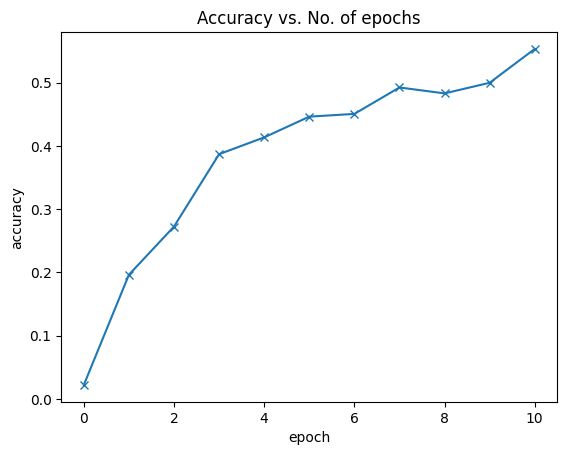

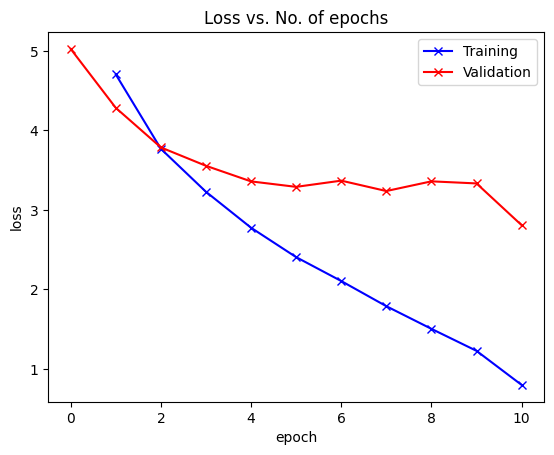

In [147]:
# Plot the accuracies and losses
plot_accuracies(history)
plot_losses(history)

In [148]:
# Evaluate the model after training
val = evaluate(model, test_dl)
print("Accuracy:", val['val_acc'])

Accuracy: 0.6115809082984924


In [149]:
# Number of FLOPs
input = torch.randn(1, 3, 112, 112).to(device)
flops = print_model_parm_flops(model, input, detail=True)

Number of FLOPs: 0.694368256
Conv FLOPs: 0.688678912
Linear FLOPs: 0.0009728
Batch Norm FLOPs: 0.004716544
ReLU FLOPs: 0.0
Pooling FLOPs: 0.0
